In [121]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics         import roc_curve

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5


# Useful functions
def compare_4top_ttV_distributions(data_4top,data_ttV,variables,myfigsize=(20,20)):
    plt.figure(figsize=myfigsize)
    i=0
    for var in variables:
        if (i>9):
            break
        i=i+1
        plt.subplot(3,3,i)
        plt.hist(data_4top[var], bins=100, histtype='step', linewidth=2.5,label='tttt')
        plt.hist(data_ttV[var] , bins=100, histtype='step', linewidth=2.5,label='ttV' )
        plt.legend()
        plt.xlabel(var)
    return


def plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY):

    plt.figure(figsize=(15,7.5))
    for sX, sY, label in [(trainX, trainY, 'Train'), (testX, testY, 'Test')]:
        predictions = np.zeros(len(sX))
        curve_rms   = []
        curve_mean  = []

        predictions = np.array( [tree.predict(sX) for tree in rf_regre.estimators_] )
        for i in range(0,rf_regre.n_estimators):
            if (i==0):
                Ypred=predictions[0]
            else:
                prediction_i = predictions[0:i]
                Ypred = np.average(prediction_i,axis=0)

            curve_rms .append( np.sqrt(np.var(Ypred-sY)) )
            curve_mean.append( np.abs(np.average(Ypred-sY)) )

        plt.subplot(221)
        plt.plot(curve_mean,label=label)
        plt.xlabel('Number of Trees')
        plt.ylabel('Biais $|\mu\,[Y-f(X)]|$')
        plt.legend()

        plt.subplot(222)
        plt.plot(curve_rms,label=label)
        plt.ylabel('Precision $\sigma\,[Y-f(X)]$')
        plt.xlabel('Number of Trees')
        plt.semilogx()
        plt.legend()

    return;


def plot_prediction_vs_truth(regressor,testX,testY):

    ypred = regressor.predict(testX)
    plt.figure(figsize=(15,5))
    
    plt.subplot(131)
    plt.xlabel('Y')
    plt.hist(testY, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='Truth')
    plt.hist(ypred, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='Prediction')
    plt.legend()

    plt.subplot(132)
    plt.xlabel('Y_{pred} - Y_{truth}')
    plt.hist(ypred-testY, bins=100, histtype='step', linewidth=2.5)

    plt.subplot(133)
    plt.xlabel('Y_{truth}')
    plt.ylabel('Y_{pred} - Y_{truth}')
    plt.plot(ypred,ypred-testY,'o')

    return


def plot_prediction_ndim(regressor,testX,testY,trainX,trainY,nvar=10):

    ypred=regressor.predict(testX)
    plt.figure(figsize=(15,15))

    i=0
    for varname in testX.columns[:nvar-1]:
        i=i+1
        x=testX[varname]
        plt.subplot(3,3,i)
        plt.plot(trainX[varname],trainY,'.',alpha=0.7, label='Data')
        plt.plot(testX[varname],ypred,'ro',alpha=0.1,label='Model')
        plt.ylabel('Y')
        plt.xlabel(varname)
        if (i==1):
            plt.legend()

    return


def plot_roc_curves(Xsig, Xbkg, variables, regressors):
    """
    Xsig      : dataframe object containing signal events
    Xbkg      : dataframe object containing background events
    variables : array of variable name that will be use to plot ROC curve
    regressors: array of [reg_method,name] where reg_method is regression and name is its legend name
    """ 
    # Prepare the full dataset
    sig_labelled = Xsig
    sig_labelled['isSig'] = True
    bkg_labelled = Xbkg
    bkg_labelled['isSig'] = False
    X = pd.concat( [sig_labelled,bkg_labelled] )

    # Produce the plots
    plt.figure(figsize=(10,8))
    for var in variables:
        fake,eff,_= roc_curve(X['isSig'],X[var])
        plt.plot(fake,eff,label=var)
    
    Xeval=X.drop('isSig',axis=1)
    Xeval.head()
    for reg,name in regressors:
        fake,eff,_= roc_curve(X['isSig'],reg.predict(Xeval))
        plt.plot(fake,eff,label=name)
    
    plt.xlabel('ttV efficiency')
    plt.ylabel('4top efficiency')
    plt.legend()
    
    return

In [122]:
data = pd.read_csv('4topSM.csv')
df = pd.DataFrame(data)
cols = df.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df = df[cols]
#df = df[df['nlep']>0] # Select events with at least one lepton
df.head()

,ht,njet,nbjet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,...,jet_isb0,jet_isb1,jet_isb2,jet_isb3,jet_isb4,jet_isb5,jet_isb6,jet_isb7,jet_isb8,m4top
0,363.195618,6,3,0,77.773085,1.056524,0.000000,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,0,0,1480.240498
1,739.406982,9,5,0,80.217866,-2.799677,0.000000,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,1279.838371
2,756.153748,9,5,1,51.067984,1.685508,125.348915,0.000000,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,995.802801
3,708.742126,5,2,2,93.307299,3.023522,40.827286,169.840958,0.000000,0.0,...,0,0,1,1,0,1,0,1,1,1382.241903
4,567.742065,5,2,3,193.714731,2.289553,105.930557,25.705399,83.422684,0.0,...,0,0,1,1,0,1,0,1,1,2706.690433


In [123]:
data_ttV = pd.read_csv('ttV.csv')
df_ttV = pd.DataFrame(data_ttV)
cols = df_ttV.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df_ttV = df_ttV[cols]
#df_ttV = df_ttV[df_ttV['nlep']>0] # Select events with at least one lepton
df_ttV.head()

,ht,njet,nbjet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,...,jet_isb0,jet_isb1,jet_isb2,jet_isb3,jet_isb4,jet_isb5,jet_isb6,jet_isb7,jet_isb8,m4top
0,898.933899,8,4,1,22.632032,-0.086053,88.720406,0.0,0.0,0.0,...,1,0,1,0,0,0,1,1,0,-99.0
1,563.983948,4,1,0,26.726042,1.816308,88.720406,0.0,0.0,0.0,...,0,0,0,1,0,0,1,1,0,-99.0
2,303.772491,6,1,0,0.000000,0.000000,88.720406,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,-99.0
3,515.249084,6,1,0,32.442406,1.914836,88.720406,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,-99.0
4,441.026398,5,2,0,23.852623,-1.567359,88.720406,0.0,0.0,0.0,...,0,0,1,1,0,0,1,1,0,-99.0


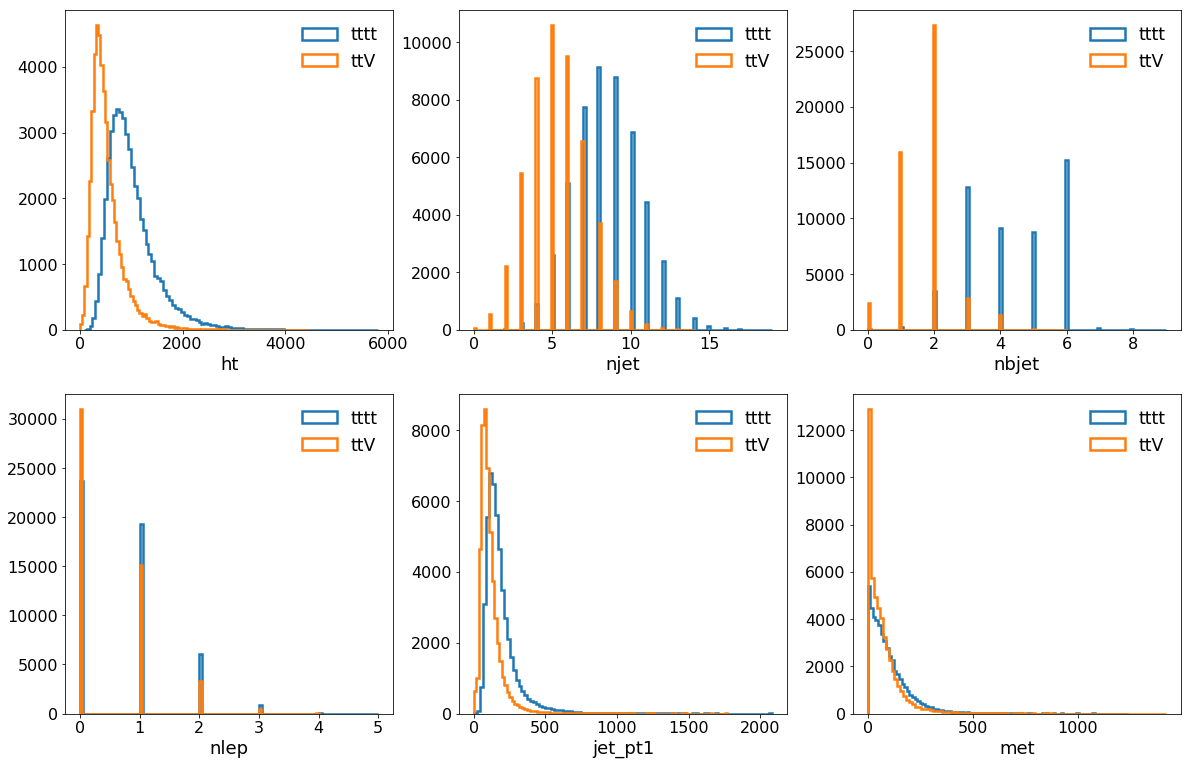

In [124]:
compare_4top_ttV_distributions(df,df_ttV,['ht','njet','nbjet','nlep','jet_pt1','met'])

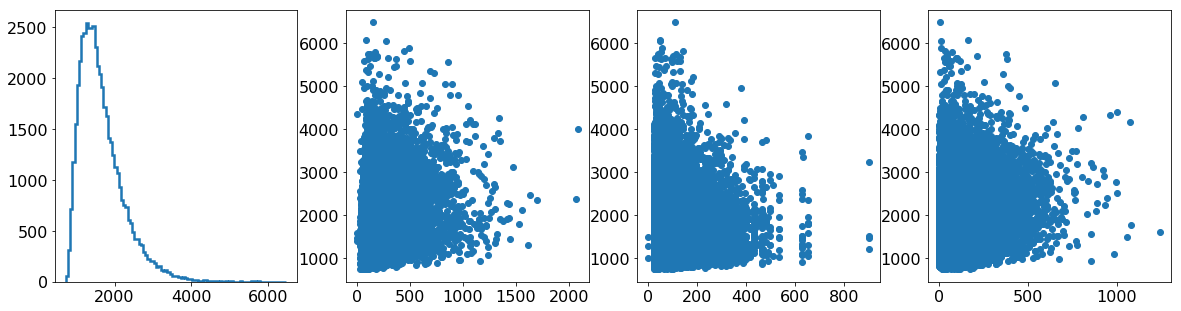

In [125]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.hist(df['m4top'], bins=100, histtype='step', linewidth=2.5,label='tttt')
plt.subplot(142)
plt.scatter(df['jet_pt1'],df['m4top'])
plt.subplot(143)
plt.scatter(df['lep_pt1'],df['m4top'])
plt.subplot(144)
plt.scatter(df['met'],df['m4top'])

In [126]:
# Features and target
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [127]:
rf_regre = RandomForestRegressor(n_estimators=500,n_jobs=-1,max_depth=15).fit(trainX, trainY)

In [ ]:
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
ab_regre = AdaBoostRegressor(n_estimators=1000, base_estimator=DecisionTreeRegressor(max_depth=10)).fit(trainX, trainY)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regre = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=10).fit(trainX,trainY)

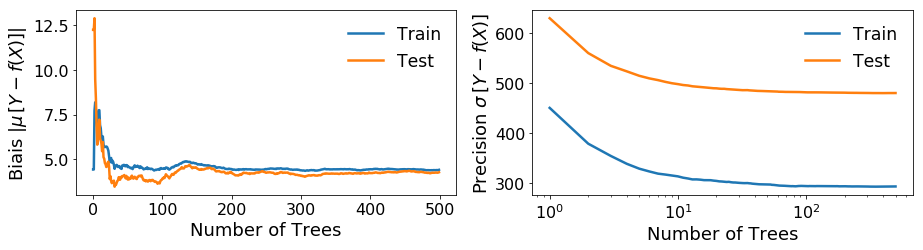

In [128]:
plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY)
plot_prediction_vs_truth(rf_regre,testX,testY)

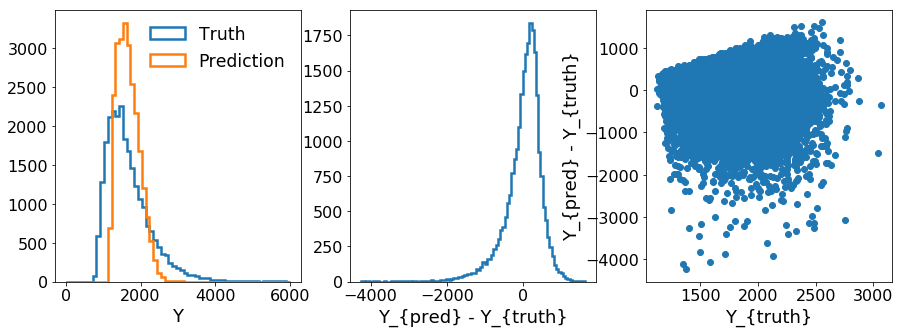

In [129]:
plot_prediction_vs_truth(ab_regre,testX,testY)

In [ ]:
plot_prediction_vs_truth(ab_regre,testX,testY)

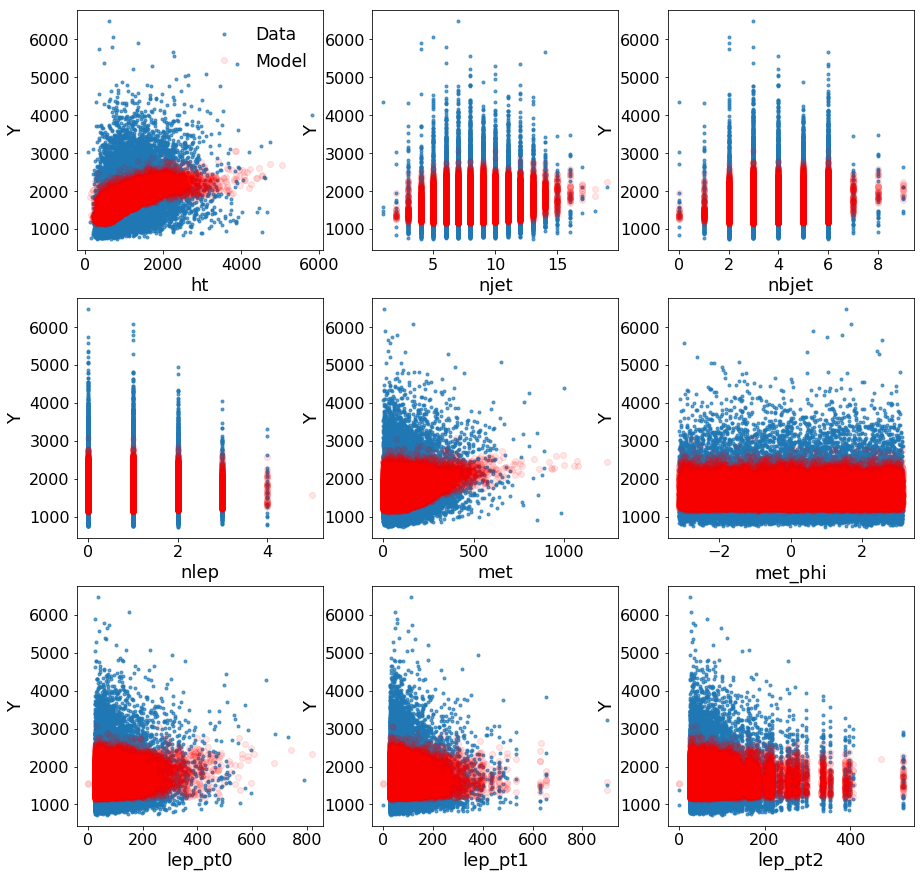

In [130]:
plot_prediction_ndim(rf_regre,testX,testY,trainX,trainY)

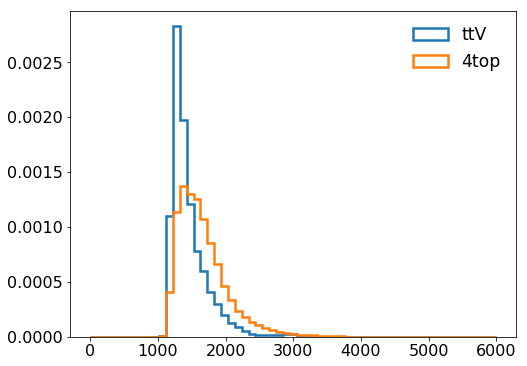

In [137]:
dataX_ttV = df_ttV.drop('m4top',axis=1)
plt.figure(figsize=(8,6))
plt.hist(rf_regre.predict(dataX_ttV), density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='ttV')
plt.hist(rf_regre.predict(trainX)   , density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='4top')
plt.legend()

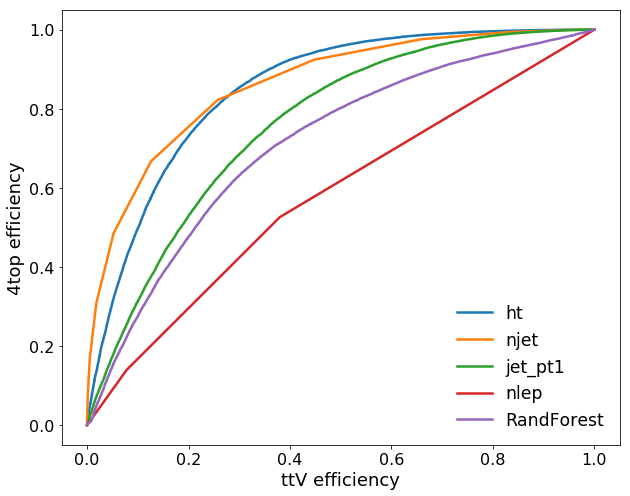

In [135]:
VariableToTest   = ['ht','njet','nbjet','jet_pt1']
RegressorsToTest = [[rf_regre,'RandForest'],[ab_regre,'AdaBoost'],[gb_regre,'GradientBoost']]
plot_roc_curves(df.drop('m4top',axis=1),df_ttV.drop('m4top',axis=1), VariableToTest, RegressorsToTest)